In [1]:
import pandas as pd
import yfinance as yf
import datetime
import time
import requests
import io
import xarray as xr

In [3]:
import os
from binance.client import Client
import pandas as pd
import datetime, time

class BinanceData :
    
    def __init__(self, howLong=180):
        self.ak = '5Zg7EUWsT3AO0BReXOZWrxZeWb2LXMhyQF9d10c24UAVFG13cv3U75jmFAzH0og2'
        self.sk = '9dvI7M4J8RjxLVUgiRqJrwux80z2BtoHlNRGaFIWyTHh55x1FgrPjzQLWs5qLXUZ'
        self.howLong = howLong
        self.client = Client(self.ak, self.sk)
        
        self.data_dict = {}
        self.ret_df = pd.DataFrame()
        
        self.base_ccy = [ 'BTC', 'ETH', 'AVAX',  'SOL', 'FTM', 'LUNA', 'ADA', ]
        


    
    def GetHistoricalData(self, tic1 = 'BNB', start_date=None, 
                          end_date=None,store = False):
        
        tic = tic1+'BUSD'
        
        # Calculate the timestamps for the binance api function
        self.untilThisDate = datetime.datetime.now() if end_date is None else end_date
        self.sinceThisDate = self.untilThisDate - datetime.timedelta(days = self.howLong) if start_date is None else start_date
        # Execute the query from binance - timestamps must be converted to strings !
        self.candle = self.client.get_historical_klines(tic, Client.KLINE_INTERVAL_1DAY, str(self.sinceThisDate), str(self.untilThisDate))

        # Create a dataframe to label all the columns returned by binance so we work with them later.
        self.df = pd.DataFrame(self.candle, columns=['dateTime', 'open', 'high', 'low', 'close', 'volume', 'closeTime', 'quoteAssetVolume', 'numberOfTrades', 'takerBuyBaseVol', 'takerBuyQuoteVol', 'ignore'])
        # as timestamp is returned in ms, let us convert this back to proper timestamps.
        self.df.dateTime = pd.to_datetime(self.df.dateTime, unit='ms').dt.strftime('%Y-%m-%d %H:%M')
        self.df.set_index('dateTime', inplace=True)

        # Get rid of columns we do not need
        self.df = self.df.drop(['closeTime', 'quoteAssetVolume', 'numberOfTrades', 'takerBuyBaseVol','takerBuyQuoteVol', 'ignore'], axis=1)
        self.df = self.df.astype('double')
        self.df.columns = [ i[0].capitalize() + i[1:]  for i in self.df.columns ]
        self.df.index.name = 'Date'
        if store :
            self.data_dict[tic1]  = self.df
            self.ret_df[tic1] = self.data_dict[tic1]['Close'].pct_change()
        
        return self.df
    


In [4]:
obj = BinanceData(howLong=10)

In [5]:
prices = obj.client.get_all_tickers()

tickers = []

stable_coins = []

for k,v in enumerate(prices) :
    if 'BUSD' == v['symbol'][-4:]:
        skip = False
        for s in stable_coins :
            if s in v['symbol'] :
                skip = True
        if not skip :
            tickers.append(v['symbol'])

In [6]:
df = obj.GetHistoricalData(tic1='BTC', start_date=pd.to_datetime('20210101'), end_date=pd.to_datetime('20210110'))

In [7]:
len( tickers )

312

In [8]:
df.tail()

,Open,High,Low,Close,Volume
Date,,,,,
2021-01-06 00:00,34048.80,37002.20,33387.97,36851.55,25492.326064
2021-01-07 00:00,36844.23,40404.26,36350.00,39488.00,25543.253481
2021-01-08 00:00,39487.99,42000.18,36588.03,40610.16,31055.166900
2021-01-09 00:00,40603.72,41430.00,38764.34,40239.25,15159.818761
2021-01-10 00:00,40239.25,41460.00,35080.12,38162.04,22678.561742


In [9]:
import pandas as pd
from ta import add_all_ta_features
from ta.utils import dropna


In [10]:
def df_to_xr(df, ukey) :
    d = df.to_xarray().to_array()
    d = d.expand_dims({'ukeys':[ukey]})
    d = d.rename({'variable':'items', 'Date':'dates'}).transpose('items', 'dates', 'ukeys')
    
    return d

    

def get_stock_data(ukey,start, end):
    try :
        df = obj.GetHistoricalData(ukey, start_date=start,end_date=end)
        #yf.download(ukey,start=start, end=end, progress=False)
        df = add_all_ta_features(df, open="Open", high="High", low="Low", close="Close", volume="Volume")
        
        ret_df = df[["Close"]].pct_change()
        ret_df.columns = ['close_ret']
        ret_xr = df_to_xr(ret_df, ukey)
        
        sig_df = df.iloc[:,6:]
        price_df = df.iloc[:,:6]
        
        sig_xr = df_to_xr(sig_df, ukey)
        price_xr = df_to_xr(price_df, ukey)
        
        return sig_xr, ret_xr, price_xr
    
    except Exception as e :
        print(ukey, e)
        print('--------------')


In [11]:
start_date = pd.to_datetime('20190101')
end_date = pd.to_datetime('20220115')


In [12]:
#%timeit a,b,c = get_stock_data('AAVE',start_date, end_date)

In [13]:
#a.dates

In [14]:
s_xr = []
r_xr = []
p_xr = []

ukeys = tickers


for i, ukey in enumerate( ukeys ) :
    ukey = ukey[:-4]
    print(i, ukey)
    
    try :
        s, r, p = get_stock_data(ukey, start=start_date, end=end_date)
        s_xr.append(s)
        r_xr.append(r)
        p_xr.append(p)
    except Exception as e :
        print(e)

0 BNB


/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)


1 BTC
2 XRP
3 ETH
4 BCHABC
5 LTC
6 LINK
7 ETC
8 TRX
9 EOS
10 XLM
11 ADA
12 BCH
13 QTUM
14 VET
15 EUR
16 BULL
17 BEAR
18 ETHBULL
19 ETHBEAR
20 ICX
21 BTS
22 BNT
23 ATOM
24 DASH
25 NEO
26 WAVES
27 XTZ
28 EOSBULL
29 EOSBEAR
30 XRPBULL
31 XRPBEAR
32 BAT
33 ENJ
34 NANO
35 ONT
36 RVN
37 STRAT
38 AION
39 ALGO
40 BTT
41 TOMO
42 XMR
43 ZEC
44 BNBBULL
BNBBULL index 14 is out of bounds for axis 0 with size 8
--------------
cannot unpack non-iterable NoneType object
45 BNBBEAR
BNBBEAR index 14 is out of bounds for axis 0 with size 8
--------------
cannot unpack non-iterable NoneType object
46 DATA
47 SOL
48 CTSI
49 ERD
50 HBAR
51 MATIC
52 WRX
53 ZIL
54 KNC
55 REP
56 LRC
57 IQ
58 GBP
59 DGB
60 COMP
61 BKRW
62 SXP
63 SNX
64 VTHO
65 DCR
66 STORJ
67 IRIS
68 MKR
69 DAI
DAI index 14 is out of bounds for axis 0 with size 8
--------------
cannot unpack non-iterable NoneType object
70 RUNE
71 MANA
72 DOGE
73 LEND
74 ZRX
75 AUD
76 FIO
77 AVA
78 IOTA
79 BAL
80 YFI
81 BLZ
82 KMD
83 JST
84 SRM
85 ANT
86 CRV
87

In [15]:
s_xr = xr.concat(s_xr, dim='ukeys')
r_xr = xr.concat(r_xr, dim='ukeys')
p_xr = xr.concat(p_xr, dim='ukeys')

In [16]:
s_xr = ( s_xr - s_xr.mean(dim='ukeys') ) / s_xr.std(dim='ukeys')

In [17]:
cor = []

for i in range(s_xr.shape[0]):
    c = s_xr[i].to_pandas().corrwith(r_xr[-1].to_pandas().shift(-1), axis=1).mean()
    print(s_xr.items.values[i], c)
    cor.append(c)

volume_obv 0.009756714959185415
volume_cmf 0.006279743677948249
volume_fi 0.008192755195558614
volume_em 0.015166306741314644
volume_sma_em 0.005606048004228003
volume_vpt -0.008473006157884298
volume_vwap -0.009285943021137675
volume_mfi 0.0008307932443391729
volume_nvi 0.009211512296058622
volatility_bbm -0.006298895442391666
volatility_bbh -0.006543379936870477
volatility_bbl -0.006355245223877321
volatility_bbw 0.0006690748632840627
volatility_bbp 0.011665512142679631
volatility_bbhi 0.00031387451361214686
volatility_bbli -0.007831077053430113
volatility_kcc -0.0054238201827632995
volatility_kch -0.0044754316783358885
volatility_kcl -0.004916676895428103
volatility_kcw -0.007356079428600832
volatility_kcp 0.011374315657010905
volatility_kchi 0.009538295532748877
volatility_kcli 0.016128778066038227
volatility_dcl -0.006241747256579978
volatility_dch -0.007088663621709897
volatility_dcm -0.006757055086740685
volatility_dcw -0.010839698337158194
volatility_dcp 0.01975628511271086
vol

In [18]:
s_xr.shape

(85, 850, 294)

In [23]:
import os as os 
import numpy as np

def create_dir(d):
    if not os.path.exists(d) :
        os.makedirs(d)

In [35]:
sig_dir = '/Users/raghuramkowdeed/Documents/AlphaExample//Crypto/TechSig_Daily/'
ret_dir = '/Users/raghuramkowdeed/Documents/AlphaExample//Crypto/Ret_Daily/'
price_dir = '/Users/raghuramkowdeed/Documents/AlphaExample//Crypto/Price_Daily/'

create_dir(sig_dir)
create_dir(ret_dir)
create_dir(price_dir)


In [36]:
dt = pd.DatetimeIndex( s_xr.dates.values)
dt = np.unique( dt.date )
# dt

In [37]:

def write_xr(data_xr, data_dir, i):
    d = pd.DatetimeIndex( data_xr['dates'])

    ind = np.where(d.date==pd.to_datetime(i))[0]

    f = data_dir + pd.to_datetime(i).strftime('%Y%m%d') +'.nc'
    data_xr[:,ind,:].to_netcdf(f) 
    

for i in dt :
    print(i)
    write_xr(s_xr, sig_dir, i)
    write_xr(r_xr, ret_dir, i)
    write_xr(p_xr, price_dir, i)


2019-09-19
2019-09-20
2019-09-21
2019-09-22
2019-09-23
2019-09-24
2019-09-25
2019-09-26
2019-09-27
2019-09-28
2019-09-29
2019-09-30
2019-10-01
2019-10-02
2019-10-03
2019-10-04
2019-10-05
2019-10-06
2019-10-07
2019-10-08
2019-10-09
2019-10-10
2019-10-11
2019-10-12
2019-10-13
2019-10-14
2019-10-15
2019-10-16
2019-10-17
2019-10-18
2019-10-19
2019-10-20
2019-10-21
2019-10-22
2019-10-23
2019-10-24
2019-10-25
2019-10-26
2019-10-27
2019-10-28
2019-10-29
2019-10-30
2019-10-31
2019-11-01
2019-11-02
2019-11-03
2019-11-04
2019-11-05
2019-11-06
2019-11-07
2019-11-08
2019-11-09
2019-11-10
2019-11-11
2019-11-12
2019-11-13
2019-11-14
2019-11-15
2019-11-16
2019-11-17
2019-11-18
2019-11-19
2019-11-20
2019-11-21
2019-11-22
2019-11-23
2019-11-24
2019-11-25
2019-11-26
2019-11-27
2019-11-28
2019-11-29
2019-11-30
2019-12-01
2019-12-02
2019-12-03
2019-12-04
2019-12-05
2019-12-06
2019-12-07
2019-12-08
2019-12-09
2019-12-10
2019-12-11
2019-12-12
2019-12-13
2019-12-14
2019-12-15
2019-12-16
2019-12-17
2019-12-18

In [30]:
s_xr.loc[:,]

<xarray.DataArray (items: 85, dates: 850, ukeys: 294)>
array([[[ 1.00000000e+00, -1.00000000e+00,             nan, ...,
                     nan,             nan,             nan],
        [ 1.00000000e+00, -1.00000000e+00,             nan, ...,
                     nan,             nan,             nan],
        [ 1.00000000e+00, -1.00000000e+00,             nan, ...,
                     nan,             nan,             nan],
        ...,
        [-6.75307579e-02, -6.75346873e-02, -6.74287505e-02, ...,
         -6.74894851e-02, -6.75296680e-02, -6.75346676e-02],
        [-6.74595974e-02, -6.74635003e-02, -6.73569593e-02, ...,
         -6.74199839e-02, -6.74584322e-02, -6.74635472e-02],
        [-6.74350861e-02, -6.74389840e-02, -6.73319108e-02, ...,
         -6.73946070e-02, -6.74340571e-02, -6.74390514e-02]],

       [[            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
...
        [ 2.63652344e-01,  1.65066796e-01,  3.22643486e-03, ...,
         -4.75668414e-01, -1.06436221e+00,  3.64080643e+00],
        [ 2.32100711e-01, -3.25558102e-01, -4.65071555e-01, ...,
         -6.97662577e-01, -3.35770512e-01, -3.01531507e+00],
        [-6.82531830e-02, -3.43717600e-01, -1.21933505e-01, ...,
          3.56027321e-01, -5.69999589e-01, -4.34692588e-01]],

       [[            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [-1.00000000e+00,  1.00000000e+00,             nan, ...,
                     nan,             nan,             nan],
        [-1.00000000e+00,  1.00000000e+00,             nan, ...,
                     nan,             nan,             nan],
        ...,
        [ 4.32984304e-01, -7.78687532e-02, -1.21476253e-01, ...,
         -1.78086105e-01, -1.77221345e-01, -1.82795078e-01],
        [ 4.43624780e-01, -7.96910919e-02, -1.23684310e-01, ...,
         -1.80206345e-01, -1.79112332e-01, -1.85905006e-01],
        [ 4.36547405e-01, -8.07726573e-02, -1.23246482e-01, ...,
         -1.78622199e-01, -1.78111281e-01, -1.84648061e-01]]])
Coordinates:
  * dates    (dates) object '2019-09-19 00:00' ... '2022-01-15 00:00'
  * ukeys    (ukeys) <U7 'BNB' 'BTC' 'XRP' 'ETH' ... 'VOXEL' 'COS' 'CTXC' 'HIGH'
  * items    (items) <U25 'volume_obv' 'volume_cmf' ... 'others_dlr' 'others_cr'

In [23]:
x = s_xr[0,:,:].to_pandas()

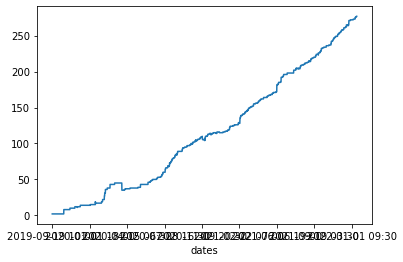

In [24]:
x.notna().sum(axis=1).plot()

In [28]:
s_xr

<xarray.DataArray (items: 85, dates: 40654, ukeys: 310)>
array([[[ 1.        , -1.        ,         nan, ...,         nan,
                 nan,         nan],
        [ 1.        , -1.        ,         nan, ...,         nan,
                 nan,         nan],
        [ 1.        , -1.        ,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [-0.06207927, -0.06208118, -0.06203701, ..., -0.06208114,
         -0.06208094, -0.06208117],
        [-0.06207964, -0.06208155, -0.06203735, ..., -0.06208151,
         -0.0620813 , -0.06208154],
        [-0.06208113, -0.06208304, -0.06203878, ..., -0.06208301,
         -0.06208279, -0.06208304]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
...
        [ 0.14362829,  0.06106608, -0.22726819, ..., -0.23327848,
         -2.55372921,  0.48745366],
        [ 0.2033563 , -0.31632211, -0.07051501, ..., -2.50690138,
          1.81494334, -0.78695691],
        [ 0.24454863,  0.00862614,  0.15922044, ...,  0.61634568,
          1.46463032,  1.10957702]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [-1.        ,  1.        ,         nan, ...,         nan,
                 nan,         nan],
        [-1.        ,  1.        ,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [ 0.54873802, -0.06734491, -0.12308346, ..., -0.17991029,
         -0.18421216, -0.17729071],
        [ 0.54961593, -0.06770593, -0.12321922, ..., -0.18045719,
         -0.1840398 , -0.17754699],
        [ 0.55215052, -0.06740625, -0.12289017, ..., -0.18016535,
         -0.18359472, -0.17711014]]])
Coordinates:
  * dates    (dates) object '2019-09-19 10:00' ... '2022-01-15 00:00'
  * ukeys    (ukeys) <U7 'BNB' 'BTC' 'XRP' 'ETH' ... 'ACH' 'IMX' 'GLMR' 'UMA'
  * items    (items) <U25 'volume_obv' 'volume_cmf' ... 'others_dlr' 'others_cr'

AttributeError: 'DataArray' object has no attribute 'date'

In [40]:
import numpy as np

d = pd.DatetimeIndex( s_xr['dates'])
ind = np.where(d.date==pd.to_datetime('2022-01-02'))[0]
ind

array([40029, 40030, 40031, 40032, 40033, 40034, 40035, 40036, 40037,
       40038, 40039, 40040, 40041, 40042, 40043, 40044, 40045, 40046,
       40047, 40048, 40049, 40050, 40051, 40052, 40053, 40054, 40055,
       40056, 40057, 40058, 40059, 40060, 40061, 40062, 40063, 40064,
       40065, 40066, 40067, 40068, 40069, 40070, 40071, 40072, 40073,
       40074, 40075, 40076])

In [41]:
s_xr[:,ind, :].dates

<xarray.DataArray 'dates' (dates: 48)>
array(['2022-01-02 00:00', '2022-01-02 00:30', '2022-01-02 01:00',
       '2022-01-02 01:30', '2022-01-02 02:00', '2022-01-02 02:30',
       '2022-01-02 03:00', '2022-01-02 03:30', '2022-01-02 04:00',
       '2022-01-02 04:30', '2022-01-02 05:00', '2022-01-02 05:30',
       '2022-01-02 06:00', '2022-01-02 06:30', '2022-01-02 07:00',
       '2022-01-02 07:30', '2022-01-02 08:00', '2022-01-02 08:30',
       '2022-01-02 09:00', '2022-01-02 09:30', '2022-01-02 10:00',
       '2022-01-02 10:30', '2022-01-02 11:00', '2022-01-02 11:30',
       '2022-01-02 12:00', '2022-01-02 12:30', '2022-01-02 13:00',
       '2022-01-02 13:30', '2022-01-02 14:00', '2022-01-02 14:30',
       '2022-01-02 15:00', '2022-01-02 15:30', '2022-01-02 16:00',
       '2022-01-02 16:30', '2022-01-02 17:00', '2022-01-02 17:30',
       '2022-01-02 18:00', '2022-01-02 18:30', '2022-01-02 19:00',
       '2022-01-02 19:30', '2022-01-02 20:00', '2022-01-02 20:30',
       '2022-01-02 21:00', '2022-01-02 21:30', '2022-01-02 22:00',
       '2022-01-02 22:30', '2022-01-02 23:00', '2022-01-02 23:30'],
      dtype=object)
Coordinates:
  * dates    (dates) object '2022-01-02 00:00' ... '2022-01-02 23:30'